In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Simple GPT example
----
This example shows the basic usage of the LUME-GPT class object used to drive GPT simulations from Python.  Typically, the first step in using a GPT object is setting up a template directory.  This directory should include the GPT input file (typically 'gpt.in') and a folder (typically named 'fields') where any field maps shoule be stored.  Here the template directory is 'lume-gpt/templates/dcgun'.  This example includes an GPT file with a dcgun followed by a solenoid, both modeled by field maps.  A static input particle GDF files is also included.  Later, creating a distribution on the fly is discussed.

In [2]:
import sys, os
root = os.path.join(os.getcwd(), '../')
sys.path.append(root)

INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')

from gpt import GPT

Initialization  of the GPT object requires providing a gpt input filename, among other possible inputs.

In [3]:
G = GPT(input_file=INPUT_FILE, verbose=True)

GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp1d796x19"


The GPT object is configured to run on initialization.  Unless specified, the simulation set to run in a temporay directory, as can be seen above.  At this point the GPT file in template directory has been read in and variables lines of the form "name = value;" have been loaded into G.input['variables']:

In [4]:
G.input['variables']

{'data_dump': 0.0,
 'Master_RF': 1300000000.0,
 'MTE': 120.0,
 'gun_voltage': 375.0,
 'sol_1_current': -3.0,
 'auto_phase': 0.0,
 'single_particle': 0.0,
 'space_charge': 1.0,
 'space_charge_type': 1.0,
 'viewscreens_on': 1.0,
 'kill_backwards_particles': 1.0,
 'optimize_on': 0.0,
 'xoffset': 0.0,
 'yoffset': 0.0,
 'RadiusMax': 0.04,
 'GBacc': 5.5,
 'xacc': 6.5,
 'dtmin': 1e-16,
 'dtmax': 1e-10,
 'ZSLA01': 0.344,
 'ZCTB01': 0.746,
 'ZSLA02': 1.16,
 'Zdcgun': 0.15,
 'Maxdcgun': 500.0,
 'SLAPolarity': -1.0,
 'LSLA01': 0.6,
 'XSLA01': 0.0,
 'YSLA01': 0.0,
 'THXSLA01': 0.0,
 'IA1SDR01_z': 0.922,
 'ZSTOP': 1.5,
 'Alpha': 1.0,
 'Fn': 0.5,
 'verror': 0.005,
 'Nstd': 5.0,
 'tree_code_theta': 1.0,
 'tree_code_R': 1e-06,
 'Ntout': 50.0,
 'tmax': 1e-08,
 'ZSTART': -0.005}

These represent all variables in the input file that can have value replacements substituted into the final gpt file used to run the simulation.  Replacements are handled by passing in a dictionary of names and values to GPT.set_variables(settings).  The function returns a dictionary of names and booleans if the variable replace was successful (a False value typically indicates the variables was not found in the input file):  

In [5]:
variables_were_set = G.set_variables({'gun_voltage':375,'sol_1_current':-3})
print(variables_were_set)

{'gun_voltage': True, 'sol_1_current': True}


To run the GPT simulation, with the above variable replacements made, simply call GPT.run():

In [6]:
G.run()

GPT.run_gpt:
   Running GPT...
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp1d796x19/gpt.in"
   Running with timeout = None sec.
   Loading GPT data from /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp1d796x19/gpt.out.gdf
   GDF data loaded, time ellapsed: 0.023896 (sec).
   Converting tout and screen data to ParticleGroup(s)
   Run finished, total time ellapsed: 1.09414 (sec)


This causes the GPT to run and the output data loaded into the GPT object.  Important data is stored in the GPT.output dictionary.  The raw screen and tout data is stored in G.screen and G.tout respectively.  The general info of the object and run can be printed using print(GPT):

In [7]:
print(G.output.keys())
print('number of touts:',G.n_tout)
print('number of screens:', G.n_screen)

# Info
print(G)

dict_keys(['particles', 'n_tout', 'n_screen', 'fields', 'start_time', 'run_time', 'run_error'])
number of touts: 32
number of screens: 1

GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp1d796x19
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.0941429138183594 (sec)


In [8]:
# Unique fingerprint based on input
G.fingerprint()

'6bdbc44360ed4db61148443c1a9e5605'

# Accessing Particle Data
The tout and screen data is automatically loaded into a single array of PMD Beam Physics ParticleGroups in `GPT.output['particles']`. Touts come first in the array, followed by screens. This data can be accessed by using the convenience functions: `GPT.particles`, `GPT.tout` and `GPT.screen`, which return the corresponding list of ParticleGroups:

In [9]:
allp = G.particles
print('Total number of particle groups:',len(allp))

touts = G.tout
print('Number of touts:',len(touts))

screens = G.screen
print('Number of screens:',len(screens))

Total number of particle groups: 33
Number of touts: 32
Number of screens: 1


Statistical quantities can be computed using `GPT.stat`.  Units are provided by `GPT.stat_units`.

In [10]:
# Some statistic that can be calculated on the particles
print('Normalized x emittances at all output:\n', G.stat('norm_emit_x'))
print(f'in units of [{G.units("norm_emit_x")}].')

Normalized x emittances at all output:
 [5.45772035e-07 6.98340485e-07 8.70680445e-07 5.62033602e-07
 5.68492605e-07 5.93715225e-07 7.90019542e-07 1.88288911e-06
 3.03540440e-06 1.57061132e-06 7.10858789e-07 5.87148488e-07
 5.72458198e-07 5.69341783e-07 5.68371385e-07 5.68314417e-07
 5.68600616e-07 5.69095167e-07 5.69853138e-07 5.70926218e-07
 5.72224154e-07 5.73746380e-07 5.75429224e-07 5.77237367e-07
 5.79173667e-07 5.81228975e-07 5.83402403e-07 5.85676976e-07
 5.88162381e-07 5.90792117e-07 5.93513968e-07 5.96340084e-07
 5.71800120e-07]
in units of [m].


This returns the statistical quantiy on all data (touts and screens). The statisical data for touts and screens individually can also be accessed using `GPT.stat(key, 'tout')` and `GPT.stat(key, 'screen')`:

In [11]:
print('Tout emittance:', G.stat('norm_emit_x','tout'))
print('Screen emittance:',G.stat('norm_emit_x','screen'))

Tout emittance: [5.45772035e-07 6.98340485e-07 8.70680445e-07 5.62033602e-07
 5.68492605e-07 5.93715225e-07 7.90019542e-07 1.88288911e-06
 3.03540440e-06 1.57061132e-06 7.10858789e-07 5.87148488e-07
 5.72458198e-07 5.69341783e-07 5.68371385e-07 5.68314417e-07
 5.68600616e-07 5.69095167e-07 5.69853138e-07 5.70926218e-07
 5.72224154e-07 5.73746380e-07 5.75429224e-07 5.77237367e-07
 5.79173667e-07 5.81228975e-07 5.83402403e-07 5.85676976e-07
 5.88162381e-07 5.90792117e-07 5.93513968e-07 5.96340084e-07]
Screen emittance: [5.7180012e-07]


# Trajectories
The particle trajectories can be accessed using `GPT.trajectories(particle_ID_number, data_type='tout')`.  Here `particle_ID_number` is a unqiue identifying integer for a specific macroparticle. 

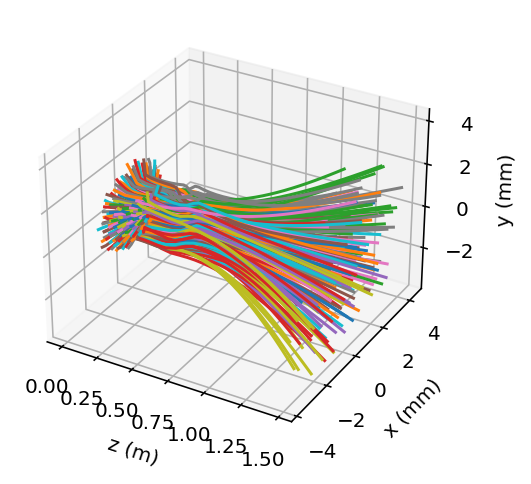

In [12]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for ii in range(1,201):
    tii = G.trajectory(ii, data_type='tout')
    ax.plot(tii['x']*1000, tii['y']*1000, tii['z'], zdir='x')
    
ax.set_xlabel('z (m)');
ax.set_ylabel('x (mm)');
ax.set_zlabel('y (mm)');

# Plot Statistics

Potting basic statistical data is then simple, simply requred the desired data from G.stat:

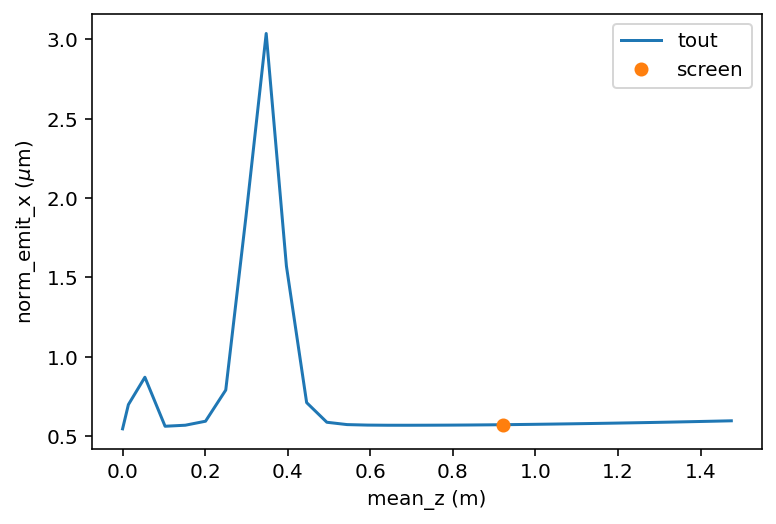

In [13]:
key1 = 'mean_z'
key2 = 'norm_emit_x'

# tout data
tdat1 = G.stat(key1,'tout')
tdat2 = G.stat(key2,'tout')

# screen data
pdat1 = G.stat(key1,'screen')
pdat2 = G.stat(key2,'screen')

units1 = G.units(key1)
units2 = G.units(key2)

fig, ax = plt.subplots()
ax.plot(tdat1, tdat2*1e6, pdat1, pdat2*1e6, 'o');
ax.set_xlabel(f'{key1} ({units1})');
ax.set_ylabel(f'{key2} ($\mu${units2})');
ax.legend(['tout','screen']);

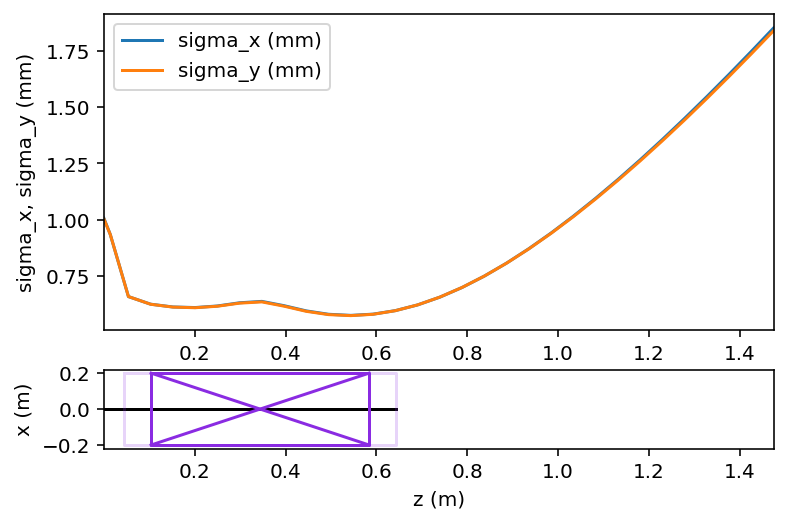

In [14]:
G.plot()

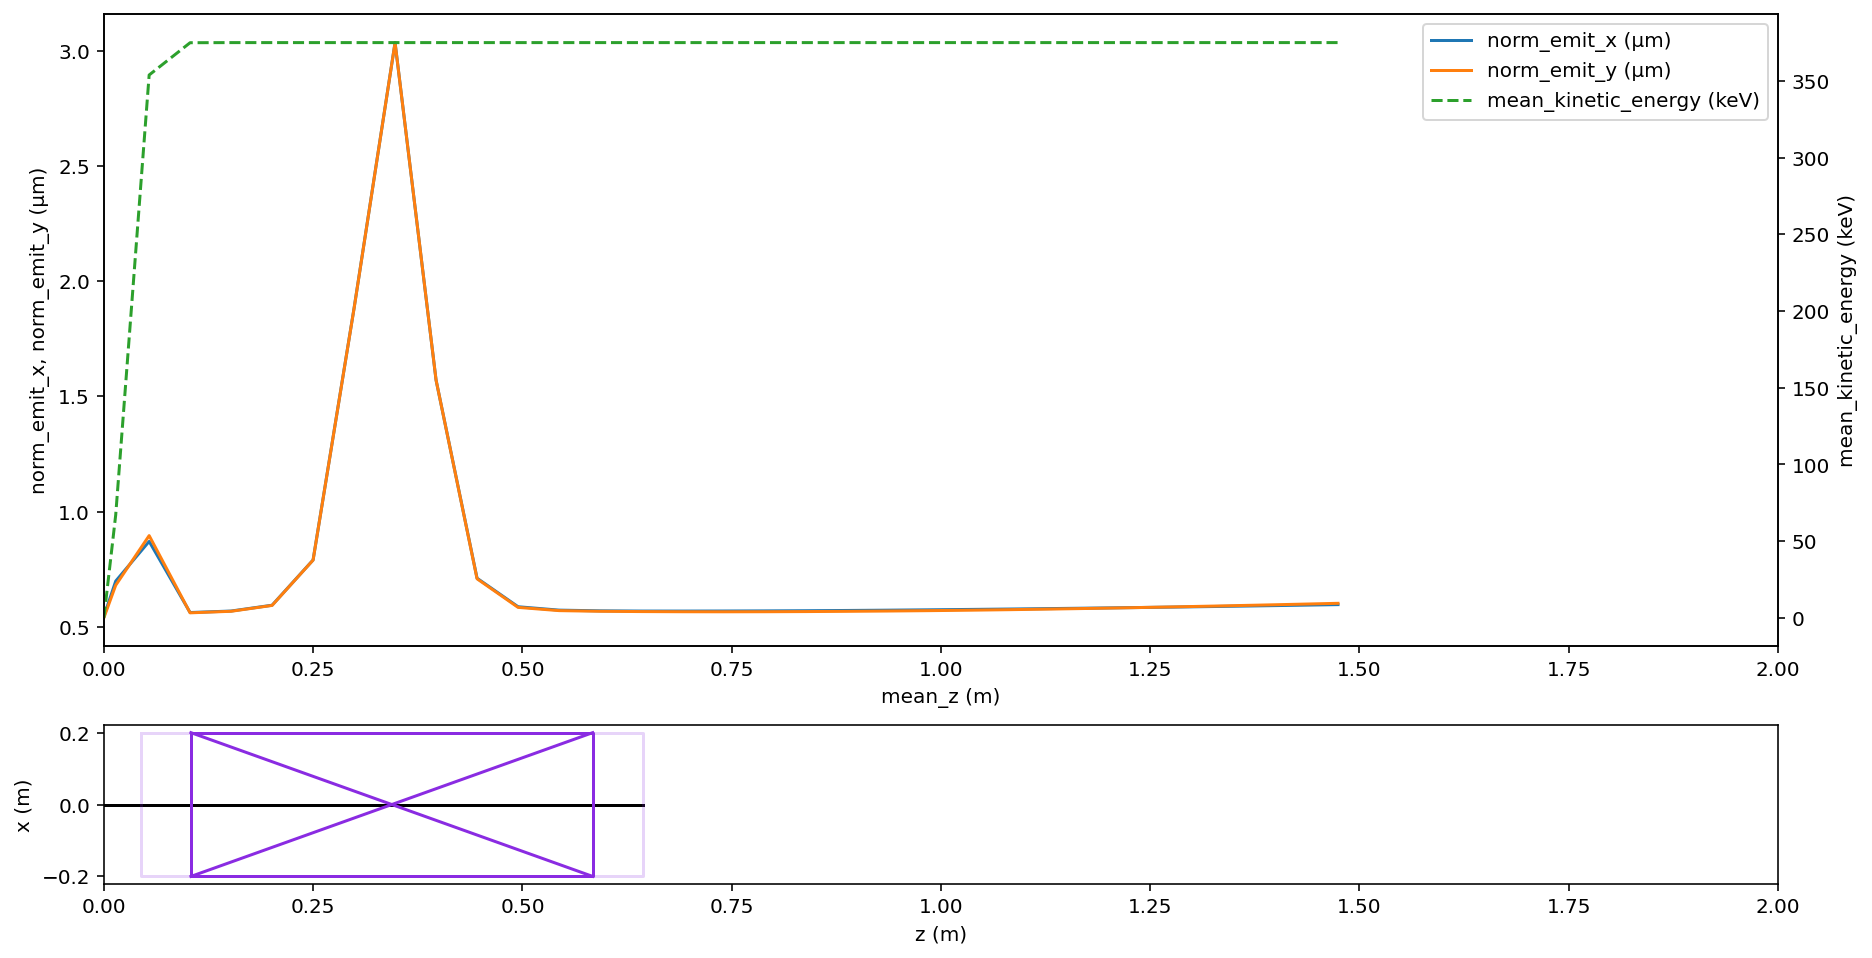

In [15]:
# Fancier options
G.plot(['norm_emit_x', 'norm_emit_y'], y2='mean_kinetic_energy', xlim = (0, 2), figsize=(15,8) )

# Particle Densities
PMD Beam Physics has some nice built in features for plotting particle distributions.  Below is a 2d histogram with marginal plots of the last tout:

In [16]:
from pmd_beamphysics.plot import marginal_plot

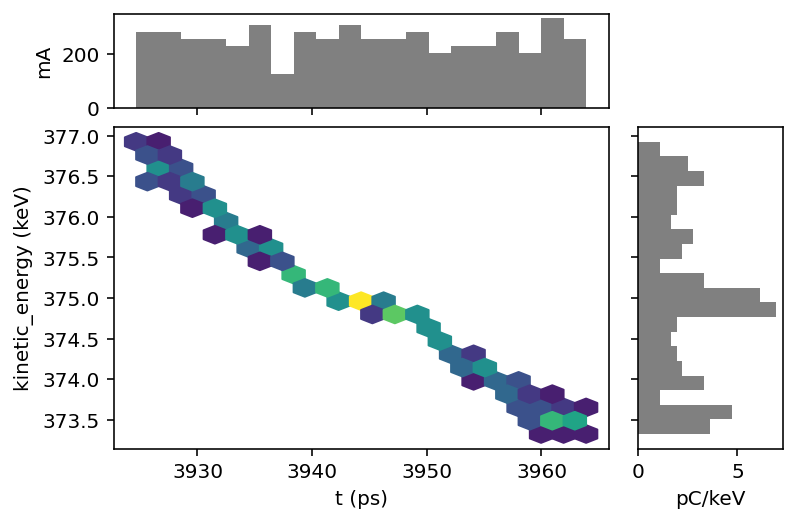

In [17]:
P = G.screen[-1]

P.plot('t', 'kinetic_energy', bins=20)

In [18]:
# Running using the run_gpt: the actions above are combined into one user function
from gpt import run_gpt

In [19]:
G = run_gpt(settings={'gun_voltage':375,'sol_1_current':-3}, gpt_input_file=INPUT_FILE, verbose=True)

run_gpt
GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpm60s2n96"
GPT.run_gpt:
   Running GPT...
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpm60s2n96/gpt.in"
   Running with timeout = 2500 sec.
   Loading GPT data from /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpm60s2n96/gpt.out.gdf
   GDF data loaded, time ellapsed: 0.0249782 (sec).
   Converting tout and screen data to ParticleGroup(s)
   Run finished, total time ellapsed: 1.08297 (sec)


In [20]:
print(G)


GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpm60s2n96
   Timeout: 2500 (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.0829730033874512 (sec)


# Passing in a openPMD-beamphysics Particle Group
Here a particle group is made via Distgen and then passed into the GPT class before running.  The particle group is written to file and used by the GPT file. This allows users to run GPT simulations with break points.  

Another useful feature this allows is for the user to set the particle ID's of the input particles, which can then be used to identify particles in the output data.  To do this first call `ParticleGroup.assign_id()` and then set the ID values using `ParticleGroup.id = user_ids`.  This is shown below.

In [21]:
from distgen import Generator
from pmd_beamphysics import ParticleGroup
import numpy as np

INPUT_FILE = os.path.join(root,'templates/dcgun_pmd/gpt.in')
DISTGEN_INPUT_FILE = os.path.join(root,'templates/dcgun_pmd/distgen.in.yaml')
gen = Generator(DISTGEN_INPUT_FILE)
beam=gen.beam()

P = ParticleGroup(data=beam.data())
P.assign_id()
N=5000
ids = np.arange(N,N+gen['n_particle'])

print('Input IDs:',ids)

P.id=ids[::-1]
G = GPT(input_file=INPUT_FILE, initial_particles = P, verbose=True)
G.run()
print(G)

print('\nOutput IDs:',G.tout[-2]['id'])

Input IDs: [5000 5001 5002 ... 6997 6998 6999]
GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun_pmd"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp9jleqt45"
GPT.run_gpt:
   Initial particles written to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp9jleqt45/gpt.particles.gdf"
   Running GPT...
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp9jleqt45/gpt.in"
   Running with timeout = None sec.
   Loading GPT data from /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp9jleqt45/gpt.out.gdf
   GDF data loaded, time ellapsed: 0.0353529 (sec).
   Converting tout and screen data to ParticleGroup(s)
   Run finished, total time ellapsed: 12.8581 (sec)

GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun_pmd
   Use temp directory: True

Run Control
   Run configured: True
   Wo

# Handling GPT Fieldmaps
----
GPT allows the user to use an array of different types of field maps.  In order to facilitate inspecting these maps, lume-gpt provides wrappers for the `gpt.maps.Map1D_E`, `gpt.maps.Map1D_B`, `gpt.maps.Map1D_TM`, `gpt.maps.Map2D_E`, `gpt.maps.Map2D_B`, and `gpt.maps.Map25D_TM`. To read the column names use `gpt.maps.get_gdf_header`, these are used to form the conversion dictionary of the column names in the GDF file to the GPT specified names for each type of map.

# Map1D_E and Map1D_B
The `gpt.maps.Map1D_E`, `gpt.maps.Map1D_B` objects give basic wrappers for the corresponding GPT field maps.  The integral of the 1D field can be accessed by `.on_axis_integral`.

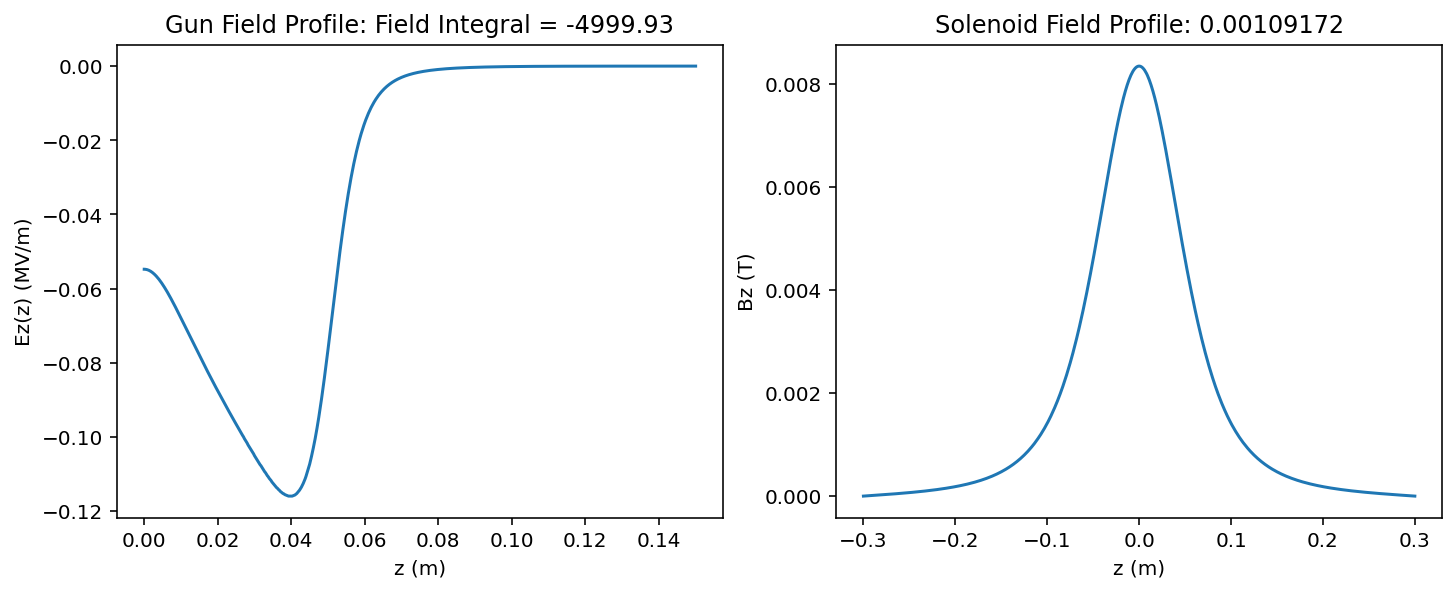

In [22]:
from gpt.maps import Map1D_E
from gpt.maps import Map1D_B
from gpt.maps import Map1D_TM
from gpt.maps import get_gdf_header

GDF_FILE = os.path.join(root,'templates/dcgun/fields/dcgun_GHV_1D.gdf');
fm1 = Map1D_E('dcgun', GDF_FILE)

GDF_FILE = os.path.join(root,'templates/dcgun/fields/solenoid_SLA_L60_1D.gdf');
fm2 = Map1D_B('sol', GDF_FILE)

fig, axs = plt.subplots(1,2,sharex='col', constrained_layout=True, figsize=[10,4]);
axs[0].plot(fm1['Z'], fm1['Ez']/1e6);
axs[0].set_xlabel('z (m)');
axs[0].set_ylabel('Ez(z) (MV/m)');
axs[0].set_title(f'Gun Field Profile: Field Integral = {fm1.field_integral:G}');

axs[1].plot(fm2['z'], fm2['Bz']);
axs[1].set_xlabel('z (m)');
axs[1].set_ylabel('Bz (T)');
axs[1].set_title(f'Solenoid Field Profile: {fm2.field_integral:G}');

# Map1D_TM

The RF equivalent of the Map1D_E and Map1D_B is the Map1D_TM.

# Map2D_E and Map2D_B

2D field maps for electrostatic and solenoid fields are handled using `gpt.field_map.Map2D_E` and `gpt.field_map.Map2D_B`:

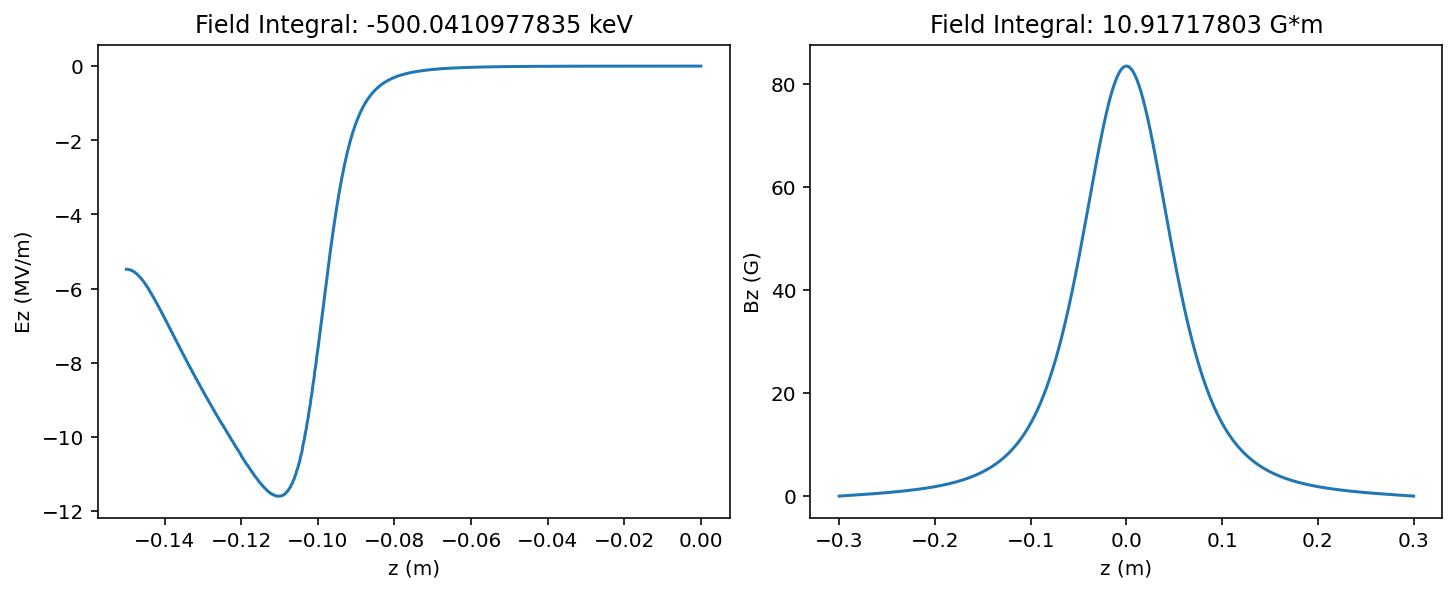

In [23]:
from gpt.maps import Map2D_E
from gpt.maps import Map2D_B

GDF_FILE = os.path.join(root,'templates/dcgun/fields/dcgun_GHV.gdf');
gun = Map2D_E('dcgun2D', GDF_FILE)

GDF_FILE = os.path.join(root,'templates/dcgun/fields/solenoid_SLA_L60.gdf');
sol = Map2D_B('sol2D', GDF_FILE)

fig, axs = plt.subplots(1, 2, sharex='col', constrained_layout=True, figsize=[10,4]);
axs[0].plot(gun.z0, gun.Ez0/1e6);
axs[0].set_xlabel('z (m)');
axs[0].set_ylabel('Ez (MV/m)');
axs[0].set_title(f'Field Integral: {gun.field_integral/1e3} keV');

axs[1].plot(sol.z0, sol.Bz0*1e4);
axs[1].set_xlabel('z (m)');
axs[1].set_ylabel('Bz (G)');
axs[1].set_title(f'Field Integral: {sol.field_integral/1e-4} G*m');

# Map25D_TM
The RF equivalent of the Map2D_E and Map2D_B is the Map25D_TM.

The field map coordinates and field components can also be scaled `.scale_coordinates` and `.scale_fields`.  To write a new GDF file use the `.write_gdf(new_gdf_file)` method.  

# GPT Driver functions
---
For ease of use the setting of variables and running of GPT is combined in several driver functions which can be used to run a GPT simulaiton.  The output of these functions is a GPT object.  

# run_gpt(...)
The simples example is run_gpt(...).  Typical use is to pass in the GPT input file and variable replacements:

In [24]:
from gpt import run_gpt
INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')
G = run_gpt(settings={'gun_voltage':375,'sol_1_current':-3},
            gpt_input_file=INPUT_FILE,
            verbose=True)

print(G)

run_gpt
GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpbqy6igg2"
GPT.run_gpt:
   Running GPT...
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpbqy6igg2/gpt.in"
   Running with timeout = 2500 sec.
   Loading GPT data from /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpbqy6igg2/gpt.out.gdf
   GDF data loaded, time ellapsed: 0.0273938 (sec).
   Converting tout and screen data to ParticleGroup(s)
   Run finished, total time ellapsed: 1.18416 (sec)

GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpbqy6igg2
   Timeout: 2500 (sec)

Results
   Finished: True
   Error occured: False
   Run time:

# run_gpt_with_distgen(...)
It is often desirable to run GPT with Distgen as the input particle source.  This is handled by gpt.run_gpt_with_distgen(...).  Used is the same as gpt.run_gpt(), except a distgen input file (or YAML string) are required:

In [25]:
from gpt import run_gpt_with_distgen
GPT_INPUT_FILE = os.path.join(root,'templates/dcgun_distgen/gpt.in')
DISTGEN_INPUT_FILE = os.path.join(root,'templates/dcgun_distgen/distgen.in.yaml')

settings = {'gun_voltage':500,
            'sol_1_current':-4.5,
            'r_dist:max_r:value':2.5,
            'total_charge:value':5,
            'total_charge:units': 'nC',
            't_dist:sigma_t:value': 0.5,
            't_dist:sigma_t:units': 'ns',
            'n_particle':200}

G = run_gpt_with_distgen(settings=settings,
                         gpt_input_file=GPT_INPUT_FILE,
                         distgen_input_file=DISTGEN_INPUT_FILE,
                         verbose=True)

print(G)

Run GPT with Distgen:
gun_voltage is in gpt
sol_1_current is in gpt
Replacing param r_dist:max_r:value with value 2.5
Replacing param total_charge:value with value 5
Replacing param total_charge:units with value nC
Replacing param t_dist:sigma_t:value with value 0.5
Replacing param t_dist:sigma_t:units with value ns
Replacing param n_particle with value 200
Linking particle files, distgen output will point to -> "distgen_gpt_particles.gdf" in working directory.
Replacing Distgen output params

Distgen >------

Distribution format: gpt
Output file: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmphjao54hd/distgen_gpt_particles.gdf

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 5 nC.
   Number of macroparticles: 200.
   Assuming cylindrical symmetry...
   r distribution: radial uniform
      min_r = 0 mm, max_r = 2.5 mm
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   t distribution: Super Gaussian
      sigma_t 

To verify this worked, inspect the initial particle distribution:

In [26]:
# Plot initial particle distribution
import numpy as np
from gpt.parsers import read_particle_gdf_file
particles=read_particle_gdf_file(os.path.join(G.tempdir.name, 'distgen_gpt_particles.gdf'))

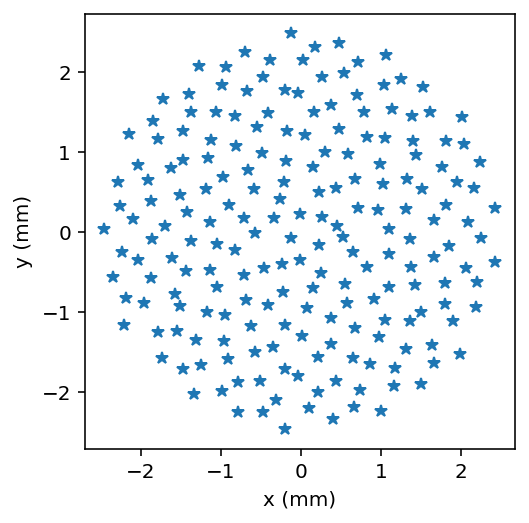

In [27]:
plt.figure()
plt.plot(1000*particles['x'],1000*particles['y'],'*')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

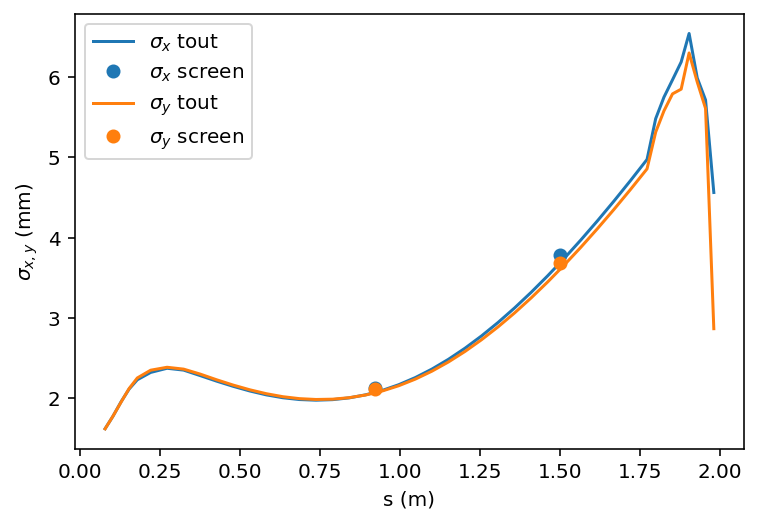

In [28]:
tavgz = G.stat('mean_z','tout')
tstdx = 1000*G.stat('sigma_x','tout')
tstdy = 1000*G.stat('sigma_y','tout')

pavgz = G.stat('mean_z','screen')
pstdx = 1000*G.stat('sigma_x','screen')
pstdy = 1000*G.stat('sigma_y','screen')

fig, ax = plt.subplots()
ax.plot(tavgz, tstdx, pavgz, pstdx, 'o', color='#1f77b4')
ax.plot(tavgz, tstdy, pavgz, pstdy, 'o', color='#ff7f0e')
ax.legend(['$\sigma_x$ tout','$\sigma_x$ screen','$\sigma_y$ tout','$\sigma_y$ screen']);
  
plt.xlabel('s (m)')
plt.ylabel('$\sigma_{x,y}$ (mm)')
plt.show()

# Evaluate GPT, and Evaluate GPT with Distgen

The Xopt optimization software requires an evaluation function to be run with GPT. This is similar to the run methods, except that the GPT object is processed by a merit function `merit_f`. If none is given, a default one will be used. Additionally, the complete object can be archived to an .h5 file with archive_path. The name will be invented based on the fingerprint

In [29]:
from gpt import evaluate_gpt
INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')
output1 = evaluate_gpt(settings={'gun_voltage':375,'sol_1_current':-3},
            gpt_input_file=INPUT_FILE,
            archive_path = '.',
                  verbose=False)
output1


{'error': False,
 'end_n_particle': 200,
 'end_norm_emit_x': 5.718001201022509e-07,
 'end_norm_emit_y': 5.678989124043604e-07,
 'end_higher_order_energy_spread': 127.43160610185197,
 'end_mean_x': 3.525212220440272e-07,
 'end_sigma_x': 0.0008536792136993227,
 'end_min_x': -0.0017967254839235188,
 'end_max_x': 0.0018794077679117423,
 'end_mean_y': -2.4146790251354746e-07,
 'end_sigma_y': 0.0008531123285433063,
 'end_min_y': -0.0019103200187470225,
 'end_max_y': 0.0021300921809371148,
 'end_mean_z': 0.9219999999999997,
 'end_sigma_z': 3.3693028157463266e-16,
 'end_min_z': 0.9219999999999999,
 'end_max_z': 0.9220000000000002,
 'end_mean_r': 0.001112098389020414,
 'end_sigma_r': 0.0004688349397506931,
 'end_min_r': 8.781865624263203e-05,
 'end_max_r': 0.002130965765081357,
 'end_mean_theta': 0.017719009827341925,
 'end_sigma_theta': 1.8097917385943312,
 'end_min_theta': -3.131876147869603,
 'end_max_theta': 3.1200691101974765,
 'end_mean_px': 0.8515362272536559,
 'end_sigma_px': 1020.95877

In [30]:
# GPT with Distgen

from gpt import evaluate_gpt_with_distgen

output2 = evaluate_gpt_with_distgen(settings,
                  gpt_input_file=GPT_INPUT_FILE,
                  distgen_input_file=DISTGEN_INPUT_FILE,
                  archive_path = '.',
                  verbose=False)

In [31]:
output2

{'error': False,
 'end_n_particle': 200,
 'end_norm_emit_x': 9.334839390228439e-06,
 'end_norm_emit_y': 9.323315817590757e-06,
 'end_higher_order_energy_spread': 496.2227257597979,
 'end_mean_x': 1.3549916208110468e-05,
 'end_sigma_x': 0.003780528705293104,
 'end_min_x': -0.007797459210918656,
 'end_max_x': 0.007997624904140127,
 'end_mean_y': 6.225962901356913e-06,
 'end_sigma_y': 0.00368226552151212,
 'end_min_y': -0.007551854230712552,
 'end_max_y': 0.007247430291283197,
 'end_mean_z': 1.5000000000000002,
 'end_sigma_z': 2.2914745035407573e-16,
 'end_min_z': 1.4999999999999998,
 'end_max_z': 1.5000000000000002,
 'end_mean_r': 0.004910210266449247,
 'end_sigma_r': 0.0019343045687176008,
 'end_min_r': 0.00019554354736554458,
 'end_max_r': 0.008330995552479455,
 'end_mean_theta': 0.04442976710081184,
 'end_sigma_theta': 1.7900488332477353,
 'end_min_theta': -3.1192156801985664,
 'end_max_theta': 3.110732085699601,
 'end_mean_px': 6.678113273693593,
 'end_sigma_px': 4015.6817161852705,


# Archiving 

The above functions produced archives. These can always be made by calling the `.archive()` method. To test this functionality, print some data from the GPT object here, then save: 



In [32]:
print('finger print:', G.fingerprint())
print('Example stat data:', G.particles[-1]['min_t'])
print('Number of touts:', G.n_tout)

afile = G.archive()


finger print: a68db3b366bd3ab3f1f0a50d08369dbf
Example stat data: 5.0823695027413724e-09
Number of touts: 44
Archiving to file gpt_a68db3b366bd3ab3f1f0a50d08369dbf.h5


In [33]:
# This can be loaded into a clean object. Check its fingerprint

G2 = GPT()
G2.load_archive(afile)
print('finger print:', G2.fingerprint())
print('example stat data:', G2.particles[-1]['min_t'])
print('N tout:', G2.n_tout)


finger print: a68db3b366bd3ab3f1f0a50d08369dbf
example stat data: 5.0823695027413724e-09
N tout: 44


In [34]:
# Check the archive above
G3 = GPT()
G3.load_archive(output2['archive'])
G3.particles[-1]['min_t']
G3.n_tout

44

In [35]:
# Cleanup
os.remove(afile)

os.remove(output1['archive'])
os.remove(output2['archive'])